## 15.5 The Ising Model

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import numba

The *Ising* model was developed to study phase transistion from a paramagnent to a ferromagnet.

- Consider a lattice of $N$ sites. 
- At each site is a number $s_i = \pm 1$ (spins).

The total energy $E$ for the Ising model is

$$E = -J \sum_{i, j = {\text n \text n}(i)}^N s_i s_j - B \sum_{i=1}^N s_i$$

- $B$ is proportional to the uniform external magnetic field
- $J$ is *exchange constant* and measures the strength between nearest neighbour spins.

The energy is given by the 1) interaction between the magnetic moments of the spins and 2) the external magnetic field.

See figure 15.1

We want the properties of an infinite system so choose periodic boundary conditions. A one-dimension lattice becomes a ring with spins at sites 1 and $N$ interacting as nearest neighbours.

Physical quantities to measure

1.  *magnetization* M given by

$$ M = \sum_{i=1}^N s_i$$

2. magnetization per spin

$$ m = M/N $$

We usually want the average values $\langle M \rangle$ and the fluctuations $\langle M^2 \rangle - \langle M \rangle^2$.

The dynamics of this system are not given by time-dependent laws (as would be the case of an ideal gas with Newton's Laws).  Here, the dynamics will take the form of various Monte Carlo algorithms.

### Demon algorithm

1. Choose a spin at random.
2. Trial changes flips spin from $\uparrow$ to $\downarrow$ or  $\downarrow$ to $\uparrow$.
2. Compute $\Delta E$, the change in the energy of the system due to the change.
3. If $\Delta E \le 0$, the system gives the amount $| \Delta E|$ to the demon, that is, $E_d = E_d - \Delta E$, and the trial configuration is accepted.
4. If $\Delta E \gt 0$ and the demon has sufficient energy for this change ($E_d \ge \Delta E)$, then the demon gives the necessary energy to the system, that is, $E_d = E_d - \Delta E$, and the trial configuration is accepted. Otherwise, the trial configuration is rejected and the configuration is not changed.

### Temperature

Two ways to measure temperature

1. Since $P(E_d) \propto e^{-E_d/kT}$, determine $T$ from the slope of the logarithm of the probabilty as function of $E_d$.

or

2. Measure mean demon energy. If $B=0$, it can be shown (see Appendix 15A) that

$$ kT/J = \frac{4}{\ln (1+4J/\langle E_d \rangle)}$$

### Implementation

Start first with the case $B=0$ (no external magnetic field) and $J=1$ (lowest energy state will be *ferromagnetic*).

We need a lattice of spins `s` with `N` elements.

In [213]:
N = 5

# start with all spins up
s = np.ones(N)

In [214]:
s

array([1., 1., 1., 1., 1.])

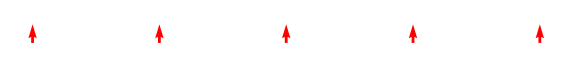

In [215]:
def plotSpins(s):
    plt.figure(figsize=(10,1))
    x = np.arange(N)
    y = np.zeros(N)
    width = 0.005
    scale = 30
   # plt.quiver(x, y, y, s, pivot='mid', width=width, scale=scale)
    plt.quiver(x[s>0], y[s>0], y[s>0], s[s>0], pivot='mid',
               width=width, scale=scale, color='red')
    plt.quiver(x[s<0], y[s<0], y[s<0], s[s<0], pivot='mid',
               width=width, scale=scale, color='green')
    plt.axis('off')

plotSpins(s)

Compute energy

$$E = -J \sum_{i, j = {\text n \text n}(i)}^N s_i s_j - B \sum_{i=1}^N s_i$$

In [216]:
def computeE(s):
    J = 1
    B = 0
    
    E = 0
    for i in range(N):
        E += - J * s[i] * s[(i+1)%N]  - B * s[i]
    return E

E = computeE(s)
E

-5.0

Compute magnetization
$$ M = \sum_{i=1}^N s_i$$

In [217]:
def computeM(s):
    M = np.sum(s)
    return M

M = computeM(s)
M

5.0

In [218]:
# system starts in ground state 
E = -N

# all spins are up initially
magnetization = N 

Pick a random spin

In [219]:
k = np.random.randint(N)
k

2

Compute energy change

In [220]:
dE = 2*s[k]*(s[(k+1) % N] + s[(k-1) % N])
dE

4.0

Since `dE > 0`, flip it

In [221]:
s[k] *= -1

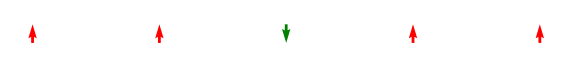

In [222]:
plotSpins(s)

Compute new energy

In [223]:
E += dE
E

-1.0

(checking we've calculated the systemEnergy correctly)

In [224]:
computeE(s)

-1.0

Compute new magneitization

In [225]:
M += 2*s[k]
M

3.0

(checking we've calculate the magneization correctly)

In [226]:
computeM(s)

3.0

Note that the system energy is not continous, but is in discrete units of $\pm 4 J$.

To initialize the system with a desired system energy, we need to try several different initial configuration.

In [ ]:
## code from previous section

class IdealDemon():
    def __init__(self, N):
        
        self.N = N
        
        # initialize to all spins being up
        self.s = np.ones(N)
        
        self.systemEnergy = E
        self.demonEnergy = 0
        
        self.v =  np.ones(self.N) * v0
        
        self.delta = 4
        
        self.reset()

    def reset(self):
        
        self.mcs = 0
        self.acceptedMoves = 0

        self.systemEnergyHistory = []        
        self.demonEnergyHistory = []

    def __str__(self):
        return f'''mcs = {self.mcs}
acceptedMoves = {self.acceptedMoves}
N = {self.N}
delta = {self.delta}
systemEnergy = {self.systemEnergy:.2f}
demonEnergy = {self.demonEnergy:.3f}
delta = {self.delta}'''
    
    def __repr__(self):
        return self.__str__()
        
    def show(self, bins=20):
        print(self)

        plt.figure()
        plt.subplot(2,1,1)
        plt.hist(self.v, bins=bins)
        plt.xlabel('v')
        plt.ylabel('number of particles')

        plt.subplot(2,1,2)
        plt.plot(self.systemEnergyHistory, label='$E$')
        plt.plot(self.demonEnergyHistory, label='$E_d$')
        plt.legend()
        plt.xlabel('mcs')
    
    def doStep(self):
        
        for j in range(self.N):
            # choose a particle at random
            particleIndex = np.random.randint(self.N)

            # random change in velocity
            dv = (2*np.random.rand() - 1)*self.delta

            trialVelocity = self.v[j] + dv
            dE = 0.5*(trialVelocity**2 - self.v[particleIndex]**2)
            
            if dE < self.demonEnergy:
                self.v[particleIndex] = trialVelocity
                self.acceptedMoves += 1
                self.systemEnergy += dE
                self.demonEnergy -= dE
        
        self.systemEnergyHistory.append(self.systemEnergy)
        self.demonEnergyHistory.append(self.demonEnergy)
        
        #increment Monte Carlo steps per particle ("time")
        self.mcs += 1
        
    def doSteps(self, m=1):
        for i in range(m):
            self.doStep()